<a href="https://colab.research.google.com/github/yohanesnuwara/geostatistics/blob/main/project_notebooks/EDA_mudlog_volve_15_9_F_15.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from bs4 import BeautifulSoup
import missingno as msno

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("classic")

import seaborn as sns
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual, ToggleButtons
import ipywidgets as widgets
from ipywidgets import interact, Dropdown

In [ ]:
from google.colab import drive
drive.mount('/content/drive') # yohannesnuwara@gmail.com Drive

Mounted at /content/drive


In [ ]:
csv_file = "/content/drive/MyDrive/GeoDatasets_Collaborative/Volve/Mud log/Realtime_mudlog.csv"

mud_df = pd.read_csv(csv_file)

mud_df.head(10)

,mudLogs,xmlns,xmlns:xsi,version,mudLog,uidWell,uidWellbore,uid,nameWell,nameWellbore,name,dTim,mudLogCompany,startMd,uom,endMd,uom.1,relatedLog,uidRef,geologyInterval,uid.1,typeLithology,mdTop,uom.2,mdBottom,uom.3,dTim.1,ropAv,uom.4,ropMn,uom.5,ropMx,uom.6,wobAv,uom.7,tqAv,uom.8,rpmAv,uom.9,wtMudAv,...,uom.26,ibutMn,uom.27,ibutMx,uom.28,nbutAv,uom.29,nbutMn,uom.30,nbutMx,uom.31,ipentAv,uom.32,ipentMn,uom.33,ipentMx,uom.34,npentAv,uom.35,npentMn,uom.36,npentMx,uom.37,mudGas,gasAv,uom.38,gasPeak,uom.39,gasBackgnd,uom.40,commonData,sourceName,dTimCreation,dTimLastChange.1,itemState,priv_userLastChange,priv_ipLastChange,priv_userOwner,priv_ipOwner,priv_dTimReceived
0,NaN,http://www.witsml.org/schemas/1series,http://www.w3.org/2001/XMLSchema-instance,1.4.1.1,NaN,dd19bf7b-02a7-4383-9038-ce201cee4d91,e0cab46e-aa2a-4d69-b466-108dafd4ae62,3RJGJ56,NO 15/9-F-15,NO 15/9-F-15 D,15/9-F-15 D,2013-12-01T21:02:30.000Z,BHI,1380.1,m,4685.0,m,DrillDepth,121RJGJ56,NaN,int1RJGJ56,interpreted,1380.1,m,1410.0,m,2013-11-10T22:49:01.000Z,0.005363,m/s,0.000400,m/s,0.001667,m/s,79490.036395,N,11037.087490,N.m,1.421590,c/s,1400.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,INTEQ,2013-11-10T06:08:22.917Z,2016-07-12T16:35:48.139Z,actual,sc-sync-bhi,143.97.229.4,statfeedstg,10.166.14.6,2016-07-08T21:37:38.651Z
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2RJGJ56,cuttings,1410.0,m,1440.0,m,2013-11-10T22:49:01.000Z,0.007997,m/s,0.001624,m/s,0.002659,m/s,49199.723551,N,10937.664001,N.m,1.999623,c/s,1400.0,...,ppm,0.0,ppm,0.0,ppm,0.0,ppm,0.0,ppm,0.0,ppm,0.0,ppm,0.0,ppm,0.0,ppm,0.0,ppm,0.0,ppm,0.0,ppm,NaN,2066.0,ppm,2078.0,ppm,2062.0,ppm,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1RJGJ56,cuttings,1410.0,m,1410.0,m,2013-11-28T22:05:13.000Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,ppm,0.0,ppm,0.0,ppm,0.0,ppm,0.0,ppm,0.0,ppm,0.0,ppm,0.0,ppm,0.0,ppm,0.0,ppm,0.0,ppm,0.0,ppm,NaN,2478.0,ppm,2522.0,ppm,2419.0,ppm,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,int2RJGJ56,interpreted,1410.0,m,1440.0,m,2013-11-11T02:57:30.000Z,0.007997,m/s,0.001624,m/s,0.002659,m/s,49199.723551,N,10937.664001,N.m,1.999623,c/s,1400.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,int3RJGJ56,interpreted,1440.0,m,1460.0,m,2013-11-14T03:54:59.000Z,0.007806,m/s,0.002668,m/s,0.003152,m/s,33501.490523,N,10582.888750,N.m,1.936630,c/s,1400.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [ ]:
np.array(mud_df.columns)

array(['mudLogs', 'xmlns', 'xmlns:xsi', 'version', 'mudLog', 'uidWell',
       'uidWellbore', 'uid', 'nameWell', 'nameWellbore', 'name', 'dTim',
       'mudLogCompany', 'startMd', 'uom', 'endMd', 'uom.1', 'relatedLog',
       'uidRef', 'geologyInterval', 'uid.1', 'typeLithology', 'mdTop',
       'uom.2', 'mdBottom', 'uom.3', 'dTim.1', 'ropAv', 'uom.4', 'ropMn',
       'uom.5', 'ropMx', 'uom.6', 'wobAv', 'uom.7', 'tqAv', 'uom.8',
       'rpmAv', 'uom.9', 'wtMudAv', 'uom.10', 'ecdTdAv', 'uom.11',
       'dxcAv', 'lithology', 'uid.2', 'type', 'codeLith', 'lithPc',
       'uom.12', 'qualifier', 'uid.3', 'type.1', 'mdTop.1', 'uom.13',
       'mdBottom.1', 'uom.14', 'abundance', 'uom.15', 'commonTime',
       'dTimLastChange', 'chromatograph', 'dTim.2', 'mdBottom.2',
       'uom.16', 'methAv', 'uom.17', 'methMn', 'uom.18', 'methMx',
       'uom.19', 'ethAv', 'uom.20', 'ethMn', 'uom.21', 'ethMx', 'uom.22',
       'propAv', 'uom.23', 'propMn', 'uom.24', 'propMx', 'uom.25',
       'ibutAv', 'uo

In [ ]:
mud_df[["dTim.1", "mdTop", "mdBottom", "mdTop.1", "mdBottom.1", "dTim.2", "mdBottom.2"]].head(10)

,dTim.1,mdTop,mdBottom,mdTop.1,mdBottom.1,dTim.2,mdBottom.2
0,2013-11-10T22:49:01.000Z,1380.1,1410.0,1380.1,1410.0,NaN,NaN
1,NaN,NaN,NaN,1380.1,1410.0,NaN,NaN
2,2013-11-10T22:49:01.000Z,1410.0,1440.0,NaN,NaN,2013-11-10T21:02:41.000Z,1440.0
3,2013-11-28T22:05:13.000Z,1410.0,1410.0,NaN,NaN,2013-11-10T19:25:41.000Z,1410.0
4,2013-11-11T02:57:30.000Z,1410.0,1440.0,1410.0,1440.0,NaN,NaN
5,NaN,NaN,NaN,1410.0,1440.0,NaN,NaN
6,NaN,NaN,NaN,1410.0,1440.0,NaN,NaN
7,2013-11-14T03:54:59.000Z,1440.0,1460.0,1440.0,1460.0,NaN,NaN
8,NaN,NaN,NaN,1440.0,1460.0,NaN,NaN
9,NaN,NaN,NaN,1440.0,1460.0,NaN,NaN


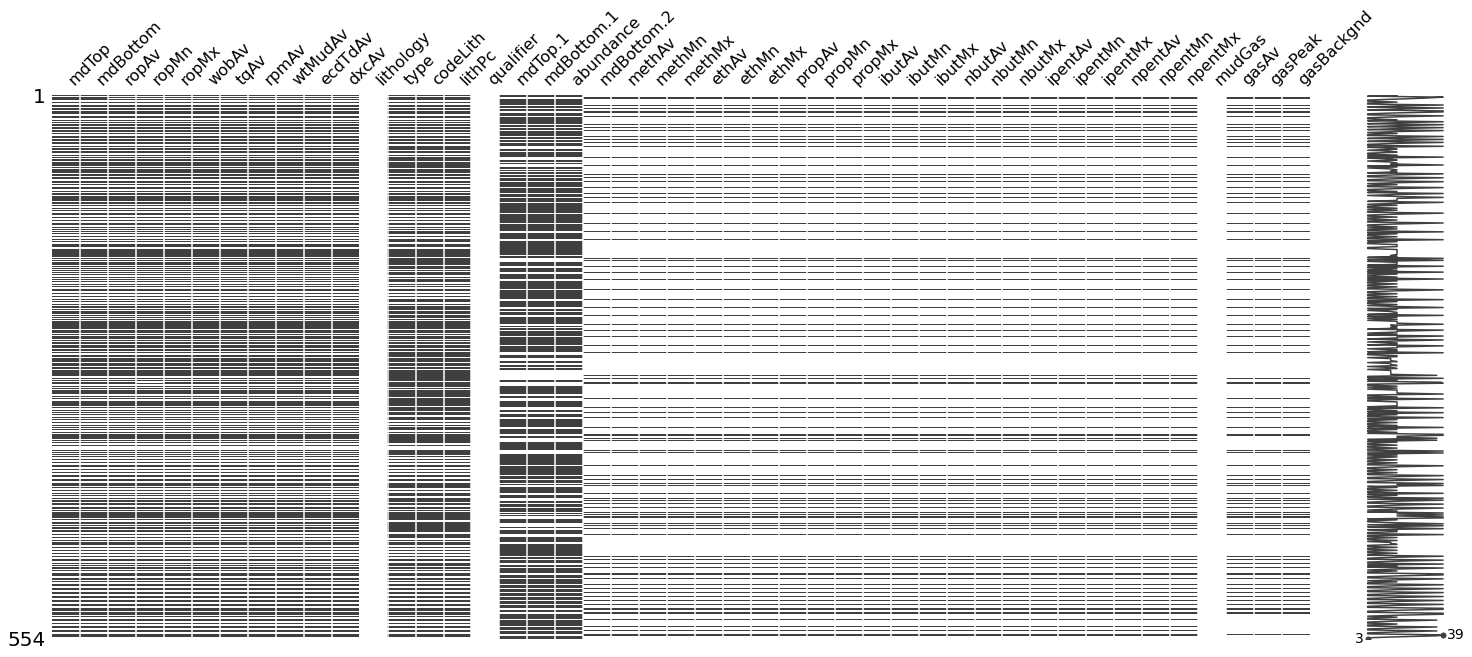

In [ ]:
mud_select_df = mud_df[["mdTop", "mdBottom", "ropAv", "ropMn", "ropMx", "wobAv", 
                        "tqAv", "rpmAv", "wtMudAv", "ecdTdAv", "dxcAv", "lithology", 
                        "type", "codeLith", "lithPc", "qualifier", "mdTop.1", 
                        "mdBottom.1", "abundance", "mdBottom.2", "methAv", "methMn", 
                        "methMx", "ethAv", "ethMn", "ethMx", "propAv", "propMn", 
                        "propMx", "ibutAv", "ibutMn", "ibutMx", "nbutAv", "nbutMn", 
                        "nbutMx", "ipentAv", "ipentMn", "ipentMx", "npentAv", 
                        "npentMn", "npentMx", "mudGas", "gasAv", "gasPeak",
                        "gasBackgnd"]]

msno.matrix(mud_select_df)
plt.show()

## Understanding structure of XML file

This is my reasoning of the structure of the XML file.

One case: When the data doesn't have <*chromatograph*> but does have <*qualifiers*> (blue box), it has GROUP 1 and GROUP 2 dataframe. GROUP 3 is Null.

> <*qualifier*> defines the mineral contents (e.g. Pyrite, Mica) of <*lithology*><*type*>. 

![image](https://user-images.githubusercontent.com/51282928/105440766-c2a0c580-5c99-11eb-8332-8c606f1d4bc7.png)

Another case: When the data doesn't have <*qualifiers*> but does have <*chromatograph*> (yellow box), it has GROUP 1 and GROUP 3. GROUP 2 is Null

> <*chromatograph*> defines the hydrocarbon content (e.g. Ethane, Methane, Propane). 

![image](https://user-images.githubusercontent.com/51282928/105442202-5a071800-5c9c-11eb-8d88-d94628a0d85d.png)

## Translate XML structure to Pandas dataframe + preprocessing

### Group 1: Mechanical + mud gas data

In [ ]:
mud_mech_df = mud_df[["dTim.1", "mdTop", "mdBottom", "ropAv", "ropMn", "ropMx", 
                      "wobAv", "tqAv", "rpmAv", "wtMudAv", "ecdTdAv",
                      "type", "dxcAv"]]

mud_mech_df.head(10)

,dTim.1,mdTop,mdBottom,ropAv,ropMn,ropMx,wobAv,tqAv,rpmAv,wtMudAv,ecdTdAv,type,dxcAv
0,2013-11-10T22:49:01.000Z,1380.1,1410.0,0.005363,0.000400,0.001667,79490.036395,11037.087490,1.421590,1400.0,1399.828964,claystone,0.808020
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-11-10T22:49:01.000Z,1410.0,1440.0,0.007997,0.001624,0.002659,49199.723551,10937.664001,1.999623,1400.0,1402.637556,claystone,0.642469
3,2013-11-28T22:05:13.000Z,1410.0,1410.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,claystone,NaN
4,2013-11-11T02:57:30.000Z,1410.0,1440.0,0.007997,0.001624,0.002659,49199.723551,10937.664001,1.999623,1400.0,1402.637556,claystone,0.642469
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2013-11-14T03:54:59.000Z,1440.0,1460.0,0.007806,0.002668,0.003152,33501.490523,10582.888750,1.936630,1400.0,1402.653782,claystone,0.597617
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Drop Null observations

In [ ]:
mud_mech_df = mud_mech_df.dropna(subset=["dTim.1", "mdTop", "mdBottom"])

mud_mech_df.head(10)

,dTim.1,mdTop,mdBottom,ropAv,ropMn,ropMx,wobAv,tqAv,rpmAv,wtMudAv,ecdTdAv,type,dxcAv
0,2013-11-10T22:49:01.000Z,1380.1,1410.0,0.005363,0.000400,0.001667,79490.036395,11037.087490,1.421590,1400.0,1399.828964,claystone,0.808020
2,2013-11-10T22:49:01.000Z,1410.0,1440.0,0.007997,0.001624,0.002659,49199.723551,10937.664001,1.999623,1400.0,1402.637556,claystone,0.642469
3,2013-11-28T22:05:13.000Z,1410.0,1410.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,claystone,NaN
4,2013-11-11T02:57:30.000Z,1410.0,1440.0,0.007997,0.001624,0.002659,49199.723551,10937.664001,1.999623,1400.0,1402.637556,claystone,0.642469
7,2013-11-14T03:54:59.000Z,1440.0,1460.0,0.007806,0.002668,0.003152,33501.490523,10582.888750,1.936630,1400.0,1402.653782,claystone,0.597617
10,2013-11-11T02:11:47.000Z,1440.0,1470.0,0.008109,0.002668,0.003398,36392.208335,10908.709126,1.958701,1400.0,1402.662987,claystone,0.605740
11,2013-11-11T02:57:31.000Z,1460.0,1500.0,0.007935,0.003160,0.003910,38287.602536,11219.619751,1.998267,1400.0,1402.699031,claystone,0.620675
13,2013-11-11T02:11:47.000Z,1470.0,1500.0,0.007676,0.003404,0.003910,37024.162808,11110.287915,1.997153,1400.0,1402.705211,claystone,0.620391
14,2013-11-11T03:35:05.000Z,1500.0,1530.0,0.007794,0.003916,0.004318,40566.284640,10469.506552,2.171137,1400.0,1402.809888,claystone,0.645573
16,2013-11-11T03:35:04.000Z,1500.0,1530.0,0.007794,0.003916,0.004318,40566.284640,10469.506552,2.171137,1400.0,1402.809888,claystone,0.645573


The appearance of "interval" (i.e. the mdTop and mdBottom) in mud logging rather than "at a depth point" just like other logs seems not common if we want to prepare for data analytics. So I do some tricks to it:

* Duplicate for each row and add it to the next row, i.e.
    * Row 0: mdTop 1,380 m; mdBottom 1,440 m 
    * Row 1: mdTop 1,380 m; mdBottom 1,440 m 

* For each one skipped row (Row 1, 3, 5, and so on), change the value of mdTop EQUAL TO mdBottom, i.e.
    * Row 0: mdTop 1,380 m; mdBottom 1,440 m 
    * Row 1: mdTop 1,440 m; mdBottom 1,440 m

* Delete mdBottom and change name "mdTop" to "md", i.e. 
    * Row 0: md 1,380 m
    * Row 1: md 1,440 m

And voila!

These are the full scripts.

In [ ]:
mud_mech_df = mud_df[["dTim.1", "mdTop", "mdBottom", "ropAv", "ropMn", "ropMx", 
                      "wobAv", "tqAv", "rpmAv", "wtMudAv", "ecdTdAv",
                      "type", "dxcAv"]]

# Convert to Panda datetime
mud_mech_df["dTim.1"] = pd.to_datetime(mud_mech_df["dTim.1"], format="%Y-%m-%dT%H:%M:%S.%fZ")

# Drop Null observations
mud_mech_df = mud_mech_df.dropna(subset=["dTim.1", "mdTop", "mdBottom"])

mud_mech_df["mdTop"] = mud_mech_df["mdTop"] + 0.5

# Duplicate every row
mud_mech_df = mud_mech_df.loc[mud_mech_df.index.repeat(2)].reset_index(drop=True)

# Change "mdTop" and "dTim.1" column name to "md" and "time"
mud_mech_df = mud_mech_df.rename(columns={"mdTop": "md", "dTim.1": "time"})

# Change value in "md" with value in "mdBottom" for every one SKIPPED row
depth = mud_mech_df["md"].values

for i in range(1, len(mud_mech_df), 2):
  depth[i] = mud_mech_df.iloc[i,:]["mdBottom"]

mud_mech_df["md"] = depth # update

# Delete "mdBottom" column
mud_mech_df = mud_mech_df.drop(columns=["mdBottom"])

# Sort "md" from smallest to highest because some values are messed up 
mud_mech_df = mud_mech_df.sort_values("md", axis=0, ascending=True).reset_index(drop=True)

mud_mech_df.to_csv("mudlog_measurements_volve_15_9_F-15.csv", index=False)

mud_mech_df.head(10)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,time,md,ropAv,ropMn,ropMx,wobAv,tqAv,rpmAv,wtMudAv,ecdTdAv,type,dxcAv
0,2013-11-10 22:49:01,1380.6,0.005363,0.000400,0.001667,79490.036395,11037.087490,1.421590,1400.0,1399.828964,claystone,0.808020
1,2013-11-10 22:49:01,1410.0,0.005363,0.000400,0.001667,79490.036395,11037.087490,1.421590,1400.0,1399.828964,claystone,0.808020
2,2013-11-28 22:05:13,1410.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,claystone,NaN
3,2013-11-10 22:49:01,1410.5,0.007997,0.001624,0.002659,49199.723551,10937.664001,1.999623,1400.0,1402.637556,claystone,0.642469
4,2013-11-28 22:05:13,1410.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,claystone,NaN
5,2013-11-11 02:57:30,1410.5,0.007997,0.001624,0.002659,49199.723551,10937.664001,1.999623,1400.0,1402.637556,claystone,0.642469
6,2013-11-10 22:49:01,1440.0,0.007997,0.001624,0.002659,49199.723551,10937.664001,1.999623,1400.0,1402.637556,claystone,0.642469
7,2013-11-11 02:57:30,1440.0,0.007997,0.001624,0.002659,49199.723551,10937.664001,1.999623,1400.0,1402.637556,claystone,0.642469
8,2013-11-14 03:54:59,1440.5,0.007806,0.002668,0.003152,33501.490523,10582.888750,1.936630,1400.0,1402.653782,claystone,0.597617
9,2013-11-11 02:11:47,1440.5,0.008109,0.002668,0.003398,36392.208335,10908.709126,1.958701,1400.0,1402.662987,claystone,0.605740


In [ ]:
mud_mech_df = mud_df[["dTim.1", "mdTop", "mdBottom", "ropAv", "ropMn", "ropMx", 
                      "wobAv", "tqAv", "rpmAv", "wtMudAv", "ecdTdAv",
                      "type", "dxcAv"]]

# Convert to Panda datetime
mud_mech_df["dTim.1"] = pd.to_datetime(mud_mech_df["dTim.1"], format="%Y-%m-%dT%H:%M:%S.%fZ")

# Drop Null observations
# mud_mech_df = mud_mech_df.dropna(subset=["dTim.1", "mdTop", "mdBottom"])
mud_mech_df = mud_mech_df.dropna()

# Taking median of "mdTop" and "mdBottom", put into new column "mdTop"
mud_mech_df["mdTop"] = (mud_mech_df["mdBottom"] + mud_mech_df["mdTop"]) / 2

# Delete "dTim"
mud_mech_df = mud_mech_df.drop(columns=["mdBottom"])

# Change "mdTop" and "dTim.1" column name to "md" and "time"
mud_mech_df = mud_mech_df.rename(columns={"mdTop": "md", "dTim.1": "time"})

# Sort "md" from smallest to highest because some values are messed up 
mud_mech_df = mud_mech_df.sort_values("md", axis=0, ascending=True).reset_index(drop=True)

mud_mech_df.to_csv("mudlog_measurements_volve_15_9_F-15.csv", index=False)

mud_mech_df.head(10)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,time,md,ropAv,ropMn,ropMx,wobAv,tqAv,rpmAv,wtMudAv,ecdTdAv,type,dxcAv
0,2013-11-10 22:49:01,1395.05,0.005363,0.000400,0.001667,79490.036395,11037.087490,1.421590,1400.0,1399.828964,claystone,0.808020
1,2013-11-10 22:49:01,1425.00,0.007997,0.001624,0.002659,49199.723551,10937.664001,1.999623,1400.0,1402.637556,claystone,0.642469
2,2013-11-11 02:57:30,1425.00,0.007997,0.001624,0.002659,49199.723551,10937.664001,1.999623,1400.0,1402.637556,claystone,0.642469
3,2013-11-14 03:54:59,1450.00,0.007806,0.002668,0.003152,33501.490523,10582.888750,1.936630,1400.0,1402.653782,claystone,0.597617
4,2013-11-11 02:11:47,1455.00,0.008109,0.002668,0.003398,36392.208335,10908.709126,1.958701,1400.0,1402.662987,claystone,0.605740
5,2013-11-11 02:57:31,1480.00,0.007935,0.003160,0.003910,38287.602536,11219.619751,1.998267,1400.0,1402.699031,claystone,0.620675
6,2013-11-11 02:11:47,1485.00,0.007676,0.003404,0.003910,37024.162808,11110.287915,1.997153,1400.0,1402.705211,claystone,0.620391
7,2013-11-11 03:35:04,1515.00,0.007794,0.003916,0.004318,40566.284640,10469.506552,2.171137,1400.0,1402.809888,claystone,0.645573
8,2013-11-11 03:35:05,1515.00,0.007794,0.003916,0.004318,40566.284640,10469.506552,2.171137,1400.0,1402.809888,claystone,0.645573
9,2013-11-11 03:36:39,1545.00,0.008400,0.004322,0.004697,45222.433760,11300.634892,2.333071,1400.0,1402.980102,claystone,0.658279


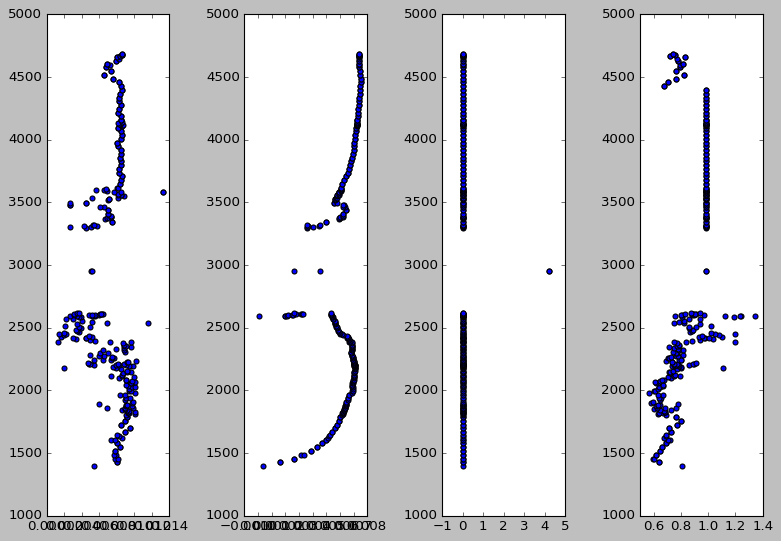

In [ ]:
df = mud_mech_df
depth = "md"
logs = ["ropAv", "ropMn", "ropMx", "dxcAv"]

plt.figure(figsize=(10,7))

for i in range(len(logs)):
  plt.subplot(1,len(logs),i+1)
  plt.scatter(df[logs[i]], df[depth])

plt.tight_layout(1.3)
plt.show()

### Group 2

Middle group is tricky. From the left group there is "type" (**lithology type**). This "type" is UNIQUE for each "mdTop" and "mdBottom". 

In this group, we have "type.1" (**mineral type**). It is ALL the composition found in the above lithology. So for example, we read from 1380 to 1410 m, the lithology is claystone. This claystone has pyrite (with abundance 5%) and mica (with abundance 5%). 

As a consequence, one lithology "type" can have TWO rows in "type.1"

In [ ]:
mud_compo_df = mud_df[["dTim.1", "mdTop.1", "mdBottom.1", "type", "type.1", "abundance"]]

mud_compo_df.head(30)

,dTim.1,mdTop.1,mdBottom.1,type,type.1,abundance
0,2013-11-10T22:49:01.000Z,1380.1,1410.0,claystone,pyrite,5.0
1,NaN,1380.1,1410.0,NaN,mica,5.0
2,2013-11-10T22:49:01.000Z,NaN,NaN,claystone,NaN,NaN
3,2013-11-28T22:05:13.000Z,NaN,NaN,claystone,NaN,NaN
4,2013-11-11T02:57:30.000Z,1410.0,1440.0,claystone,mica,5.0
5,NaN,1410.0,1440.0,NaN,pyrite,5.0
6,NaN,1410.0,1440.0,NaN,calcareous,5.0
7,2013-11-14T03:54:59.000Z,1440.0,1460.0,claystone,calcareous,5.0
8,NaN,1440.0,1460.0,NaN,mica,3.0
9,NaN,1440.0,1460.0,NaN,pyrite,5.0


### Group 3: Chromatograph data

In [ ]:
mud_chrom_df = mud_df[["dTim.2", "mdBottom.2", "methAv", "methMn", "methMx", "ethAv", "ethMn", "ethMx",
        "propAv", "propMn", "propMx", "ibutAv", "ibutMn", "ibutMx",
        "nbutAv", "nbutMn", "nbutMx", "ipentAv", "ipentMn", "ipentMx",
        "npentAv", "npentMn", "npentMx", "gasAv", "gasPeak", "gasBackgnd"]]

mud_chrom_df.head(10)

,dTim.2,mdBottom.2,methAv,methMn,methMx,ethAv,ethMn,ethMx,propAv,propMn,propMx,ibutAv,ibutMn,ibutMx,nbutAv,nbutMn,nbutMx,ipentAv,ipentMn,ipentMx,npentAv,npentMn,npentMx,gasAv,gasPeak,gasBackgnd
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-11-10T21:02:41.000Z,1440.0,1613.0,231.0,2490.0,-2.978426e+09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2066.0,2078.0,2062.0
3,2013-11-10T19:25:41.000Z,1410.0,1648.0,1648.0,1648.0,-9.990000e+02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2478.0,2522.0,2419.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Drop Null observations.

In [ ]:
mud_chrom_df = mud_chrom_df.dropna(subset=["dTim.2", "mdBottom.2"])

mud_chrom_df.head(10)

,dTim.2,mdBottom.2,methAv,methMn,methMx,ethAv,ethMn,ethMx,propAv,propMn,propMx,ibutAv,ibutMn,ibutMx,nbutAv,nbutMn,nbutMx,ipentAv,ipentMn,ipentMx,npentAv,npentMn,npentMx,gasAv,gasPeak,gasBackgnd
2,2013-11-10T21:02:41.000Z,1440.0,1613.0,231.0,2490.0,-2.978426e+09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2066.0,2078.0,2062.0
3,2013-11-10T19:25:41.000Z,1410.0,1648.0,1648.0,1648.0,-9.990000e+02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2478.0,2522.0,2419.0
10,2013-11-21T15:52:28.000Z,1470.0,1306.0,15.0,3526.0,0.000000e+00,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2223.0,4317.0,132.0
13,2013-11-21T15:53:17.000Z,1500.0,2042.0,21.0,4423.0,0.000000e+00,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2722.0,2981.0,2528.0
16,2013-11-21T15:54:05.000Z,1530.0,1760.0,21.0,4086.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2772.0,2813.0,2724.0
17,2013-11-21T15:54:55.000Z,1560.0,1939.0,13.0,4846.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5057.0,5074.0,5035.0
21,2013-11-29T23:55:21.000Z,1590.0,-67373.0,16.0,31589.0,-7.613000e+03,0.0,2924.0,-3444.0,0.0,1507.0,-316.0,0.0,142.0,-783.0,0.0,410.0,-146.0,0.0,100.0,-146.0,0.0,136.0,6055.0,6070.0,6031.0
27,2013-11-21T15:56:33.000Z,1620.0,2615.0,21.0,5077.0,0.000000e+00,0.0,0.0,-536859060.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,306.0,518.0,134.0
30,2013-11-21T15:57:22.000Z,1650.0,2291.0,21.0,5221.0,0.000000e+00,0.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3157.0,3245.0,3059.0
33,2013-11-21T15:58:11.000Z,1680.0,2319.0,14.0,5437.0,0.000000e+00,0.0,5.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3340.0,6581.0,134.0


Chromatograph data here isn't like the previous GROUP 1 data. It has only mdBottom. So, I assume mdBottom to be the Measured Depth (md) instead.

What about the minus large values, e.g. -90100 ppm ???

Here's the full script.

In [ ]:
mud_chrom_df = mud_df[["dTim.2", "mdBottom.2", "methAv", "methMn", "methMx", 
                       "ethAv", "ethMn", "ethMx", "propAv", "propMn", "propMx", 
                       "ibutAv", "ibutMn", "ibutMx", "nbutAv", "nbutMn", "nbutMx", 
                       "ipentAv", "ipentMn", "ipentMx", "npentAv", "npentMn", 
                       "npentMx", "gasAv", "gasPeak", "gasBackgnd"]]

# Drop Null observations
mud_chrom_df = mud_chrom_df.dropna(subset=["dTim.2", "mdBottom.2"]).reset_index(drop=True)

# Convert to Panda datetime
mud_chrom_df["dTim.2"] = pd.to_datetime(mud_chrom_df["dTim.2"], format="%Y-%m-%dT%H:%M:%S.%fZ")

# Change "mdBottom.2" and "dTim.2" column name to "md" and "time"
mud_chrom_df = mud_chrom_df.rename(columns={"mdBottom.2": "md", "dTim.2": "time"})

mud_chrom_df.to_csv("mudlog_chromatograph_volve_15_9_F-15.csv", index=False)

mud_chrom_df.head(10)

,time,md,methAv,methMn,methMx,ethAv,ethMn,ethMx,propAv,propMn,propMx,ibutAv,ibutMn,ibutMx,nbutAv,nbutMn,nbutMx,ipentAv,ipentMn,ipentMx,npentAv,npentMn,npentMx,gasAv,gasPeak,gasBackgnd
0,2013-11-10 21:02:41,1440.0,1613.0,231.0,2490.0,-2.978426e+09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2066.0,2078.0,2062.0
1,2013-11-10 19:25:41,1410.0,1648.0,1648.0,1648.0,-9.990000e+02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2478.0,2522.0,2419.0
2,2013-11-21 15:52:28,1470.0,1306.0,15.0,3526.0,0.000000e+00,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2223.0,4317.0,132.0
3,2013-11-21 15:53:17,1500.0,2042.0,21.0,4423.0,0.000000e+00,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2722.0,2981.0,2528.0
4,2013-11-21 15:54:05,1530.0,1760.0,21.0,4086.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2772.0,2813.0,2724.0
5,2013-11-21 15:54:55,1560.0,1939.0,13.0,4846.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5057.0,5074.0,5035.0
6,2013-11-29 23:55:21,1590.0,-67373.0,16.0,31589.0,-7.613000e+03,0.0,2924.0,-3444.0,0.0,1507.0,-316.0,0.0,142.0,-783.0,0.0,410.0,-146.0,0.0,100.0,-146.0,0.0,136.0,6055.0,6070.0,6031.0
7,2013-11-21 15:56:33,1620.0,2615.0,21.0,5077.0,0.000000e+00,0.0,0.0,-536859060.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,306.0,518.0,134.0
8,2013-11-21 15:57:22,1650.0,2291.0,21.0,5221.0,0.000000e+00,0.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3157.0,3245.0,3059.0
9,2013-11-21 15:58:11,1680.0,2319.0,14.0,5437.0,0.000000e+00,0.0,5.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3340.0,6581.0,134.0


## EDA

### Mechanical data

#### Scatter plots

I don't like seaborn.

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:306: UserWarning:

Dataset has 0 variance; skipping density estimate.

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:306: UserWarning:

Dataset has 0 variance; skipping density estimate.

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:306: UserWarning:

Dataset has 0 variance; skipping density estimate.

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:306: UserWarning:

Dataset has 0 variance; skipping density estimate.

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:306: UserWarning:

Dataset has 0 variance; skipping density estimate.

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:306: UserWarning:

Dataset has 0 variance; skipping density estimate.

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:306: UserWarning:

Dataset has 0 variance; skipping density estimate.



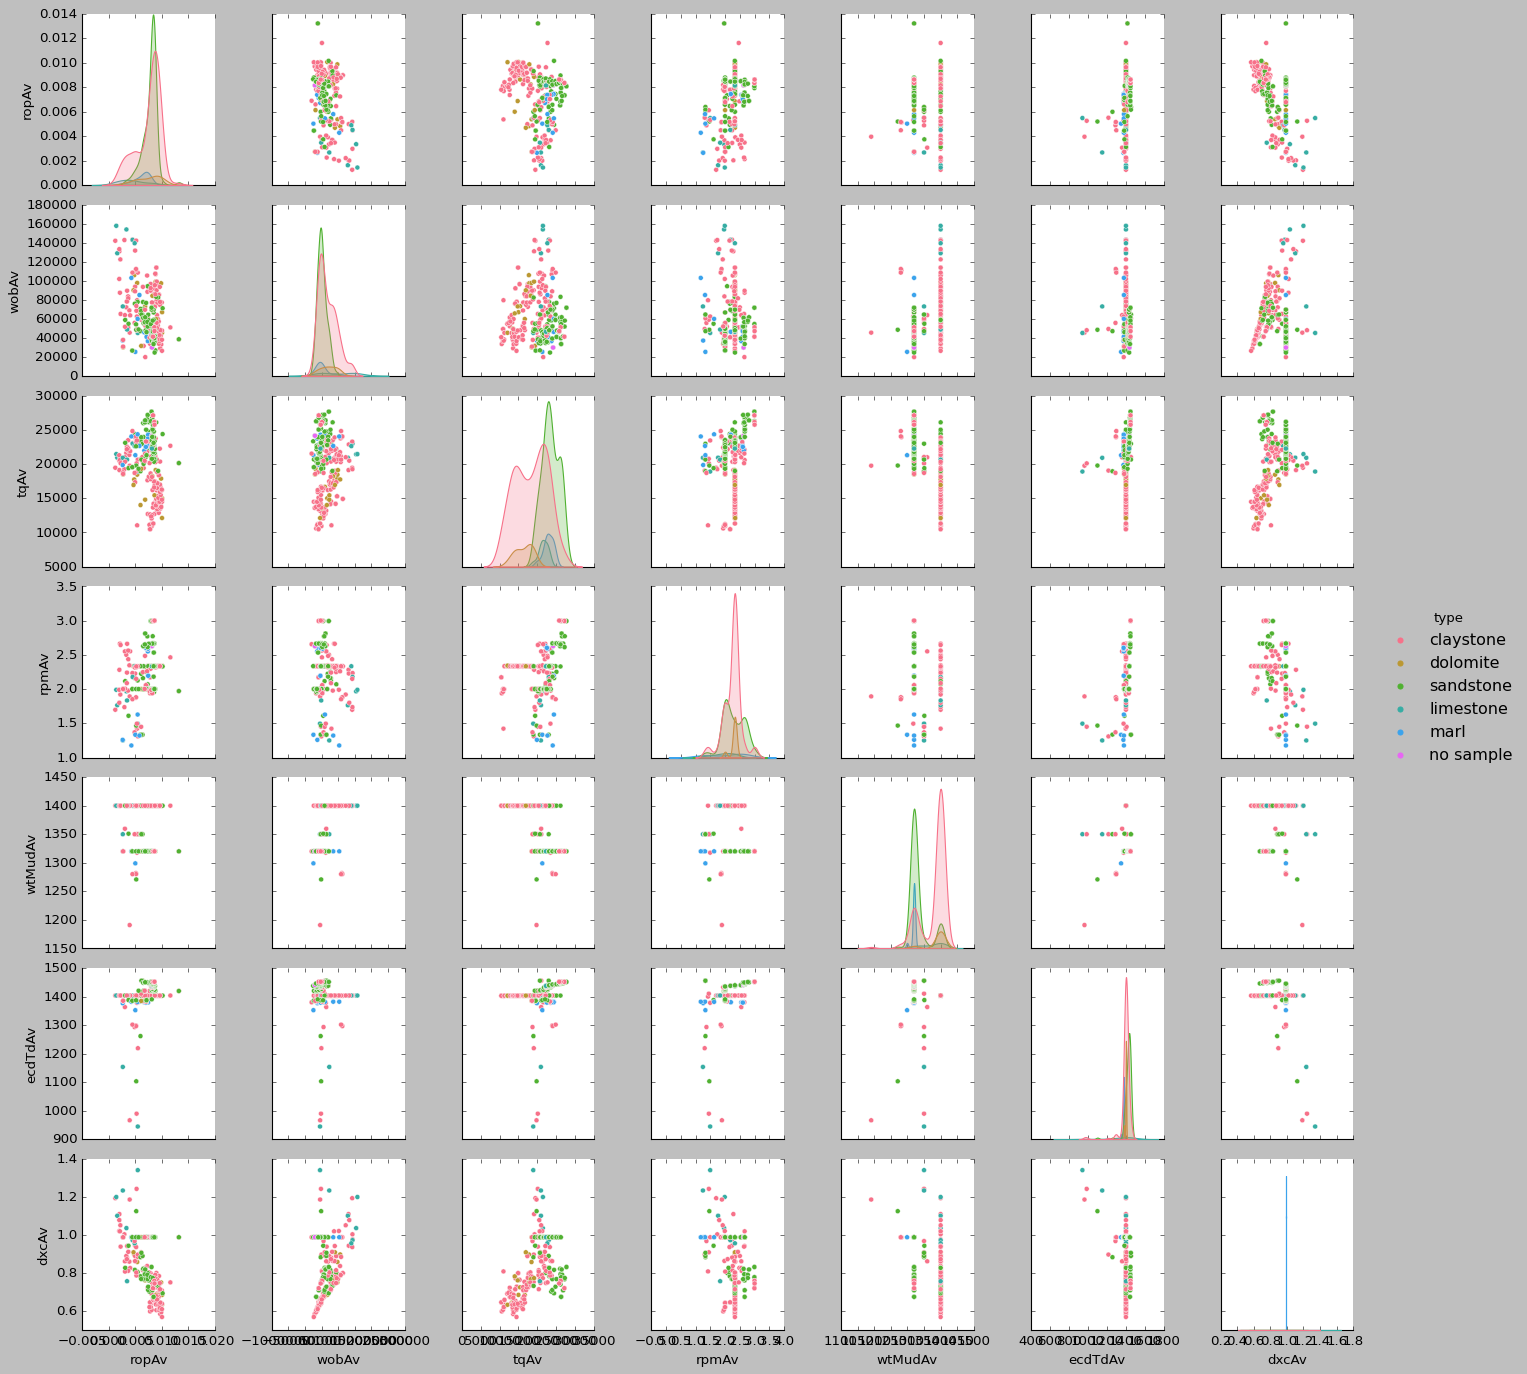

In [ ]:
sns.pairplot(mud_mech_df[["ropAv", "wobAv", "tqAv", "rpmAv", "wtMudAv", "ecdTdAv", "dxcAv", "type"]],
             hue="type")
plt.show()

I prefer Plotly because it's interactive and simple to make it interactive.

In [ ]:
import plotly.express as px

df = mud_mech_df
logs = ["ropAv", "wobAv", "tqAv", "rpmAv", "wtMudAv", "ecdTdAv", "dxcAv"]
color = "type"

fig = px.scatter_matrix(df, dimensions=logs, color=color, symbol=color,
                        height=1000, width=1000, title="Scatter Plot Matrix")
fig.update_traces(showupperhalf=False, diagonal_visible=False)
fig.show()

In [ ]:
hover_data = "md"

@interact

def f(x_axis=logs, y_axis=logs, z_axis=logs,
      color_by=color):
  fig = px.scatter_3d(df, x=x_axis, y=y_axis, z=z_axis, color=color_by,
                      hover_data=[hover_data])
  fig.show()

interactive(children=(Dropdown(description='x_axis', options=('ropAv', 'wobAv', 'tqAv', 'rpmAv', 'wtMudAv', 'e…

In [ ]:
@interact

def f(x_axis=logs, y_axis=logs, color_by=color):
  fig = px.scatter(df, x=x_axis, y=y_axis, color=color_by,
                  marginal_x="histogram", marginal_y="histogram",
                  width=700, height=700)
  fig.show()

interactive(children=(Dropdown(description='x_axis', options=('ropAv', 'wobAv', 'tqAv', 'rpmAv', 'wtMudAv', 'e…

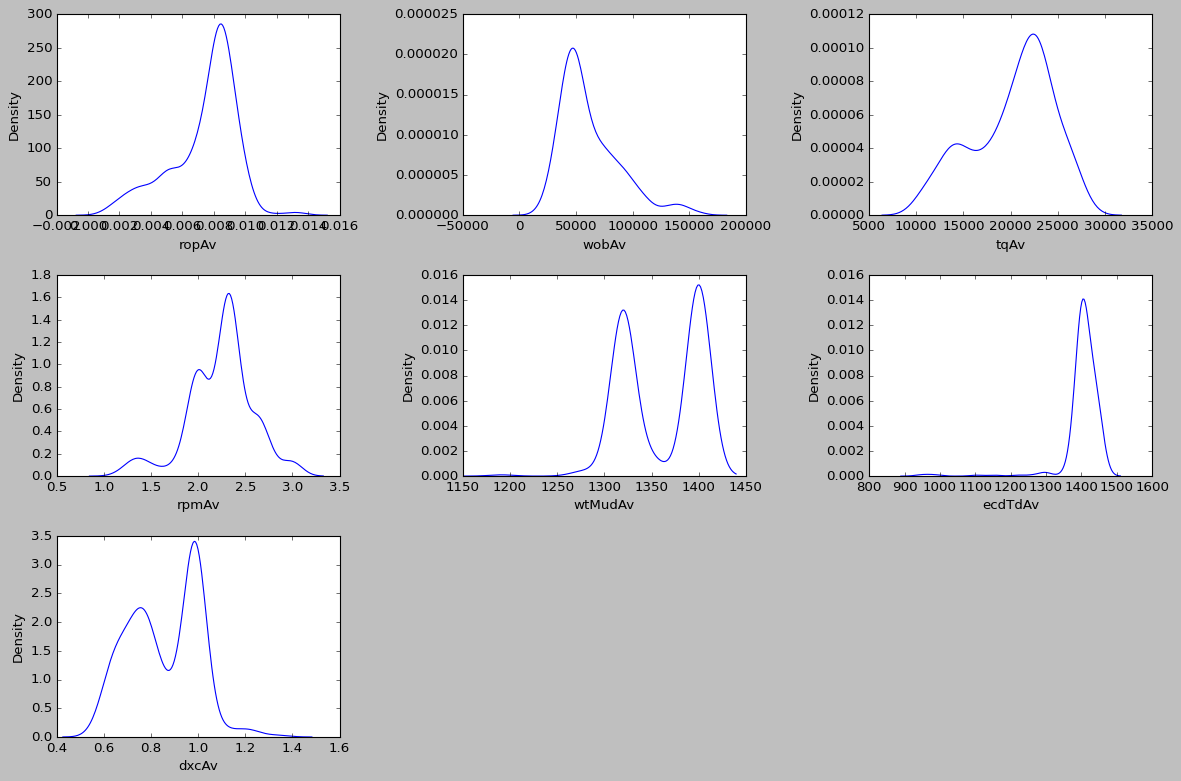

In [ ]:
plt.figure(figsize=(15,10))

for i in range(len(logs)):
  plt.subplot(3,3,i+1)
  sns.kdeplot(df[logs[i]])

plt.tight_layout(1.3)
plt.show()

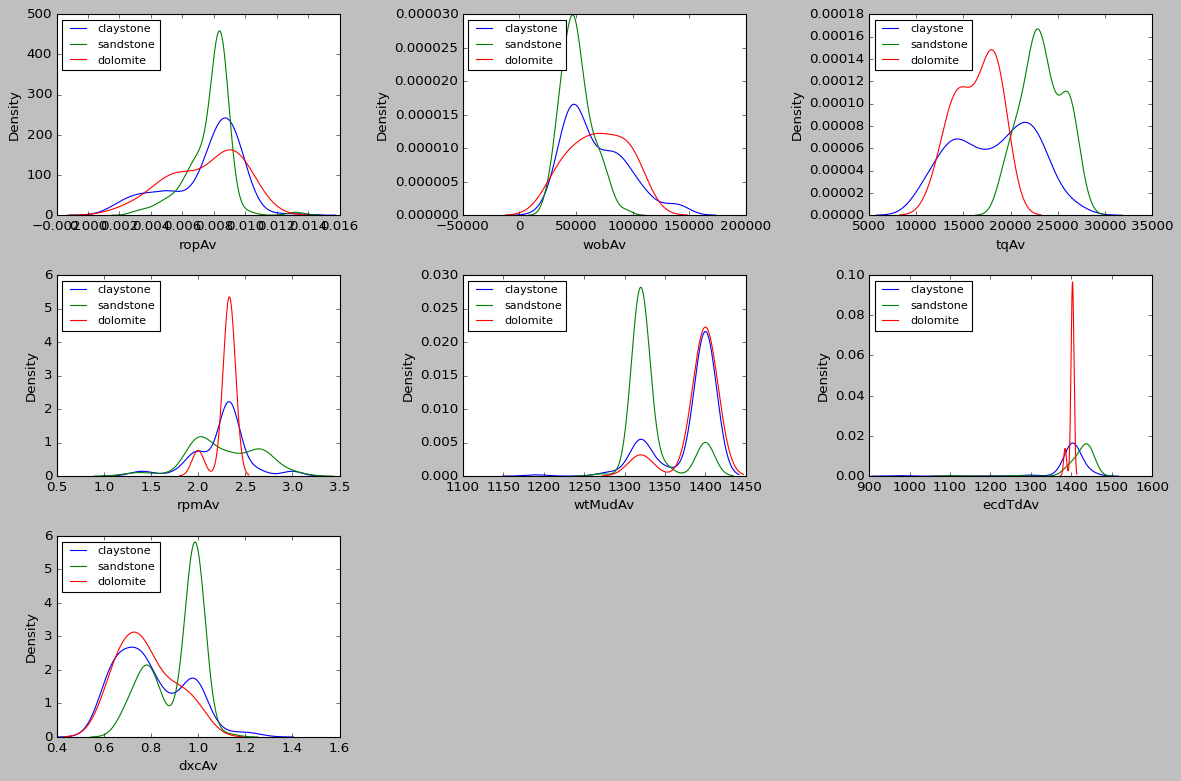

In [ ]:
df = mud_mech_df
logs = ["ropAv", "wobAv", "tqAv", "rpmAv", "wtMudAv", "ecdTdAv", "dxcAv"]
color = "type"

# lithotype = mud_mech_df[color].unique()
lithotype = ["claystone", "sandstone", "dolomite"]

plt.figure(figsize=(15,10))

for i in range(len(logs)):
  plt.subplot(3,3,i+1)  
  for j in range(len(lithotype)):
    z = df[df[color] == lithotype[j]] 
    sns.kdeplot(z[logs[i]], Label=lithotype[j])
    # plt.legend(fontsize=10,bbox_to_anchor=(1.5, 1), borderaxespad=0) # Legend outside plot
    plt.legend(fontsize=10, loc="upper left") # Legend outside plot

plt.tight_layout(1.3)
plt.show()

#### Box plots

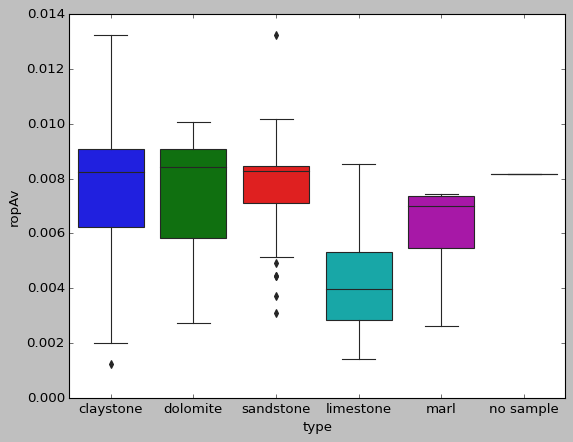

In [ ]:
sns.boxplot(x=df["type"], y=df["ropAv"])
plt.show()

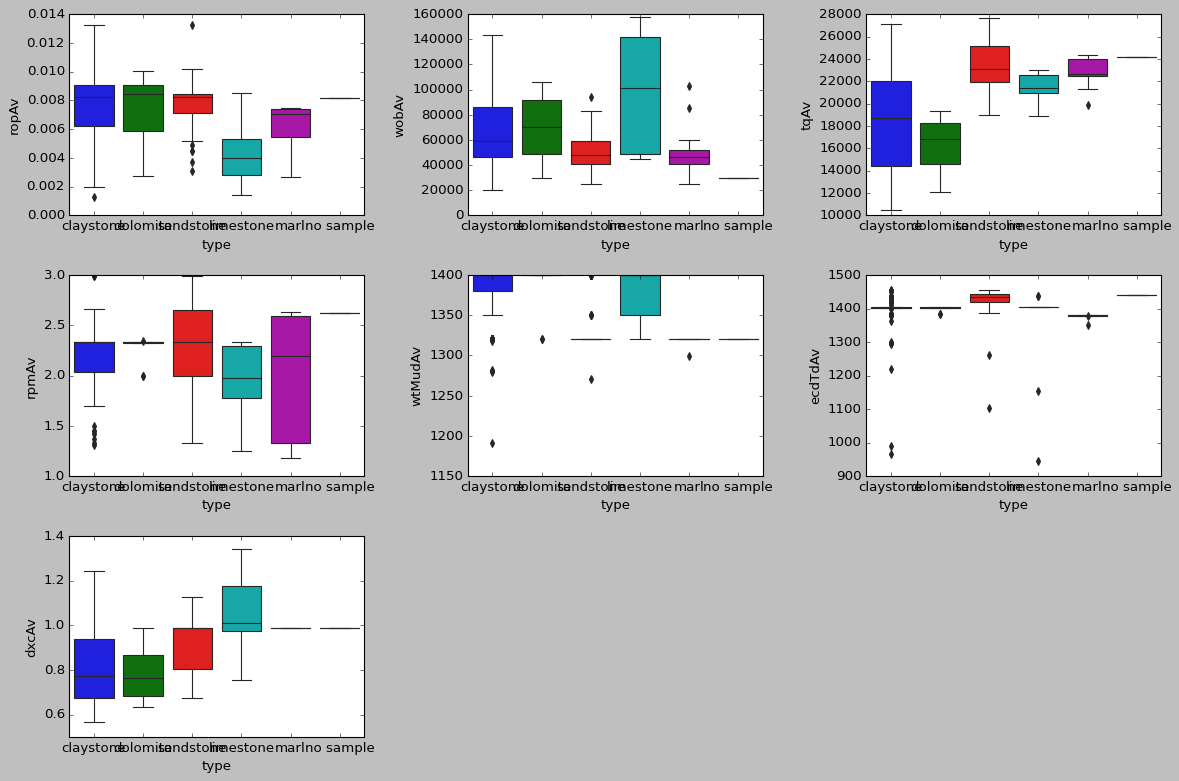

In [ ]:
df = mud_mech_df
logs = ["ropAv", "wobAv", "tqAv", "rpmAv", "wtMudAv", "ecdTdAv", "dxcAv"]
color = "type"

plt.figure(figsize=(15,10))

for i in range(len(logs)):
  plt.subplot(3,3,i+1)
  sns.boxplot(x=df[color], y=df[logs[i]])

plt.tight_layout(1.3)
plt.show()

In [ ]:
# df.ropAv.groupby([df['time'].dt.date]).boxplot(subplots=False)
df.ropAv.groupby([df['time'].dt.date]).describe()
# plt.show()

,count,mean,std,min,25%,50%,75%,max
time,,,,,,,,
2013-11-10,2.0,0.006680,0.001863,0.005363,0.006022,0.006680,0.007339,0.007997
2013-11-11,15.0,0.008017,0.000319,0.007361,0.007794,0.007997,0.008158,0.008633
2013-11-12,37.0,0.009103,0.000777,0.005995,0.008921,0.009168,0.009520,0.010060
2013-11-13,7.0,0.009306,0.000565,0.008254,0.009135,0.009350,0.009619,0.010030
2013-11-14,7.0,0.008773,0.000720,0.007806,0.008257,0.009020,0.009138,0.009794
2013-11-15,14.0,0.007993,0.001523,0.004679,0.007362,0.008374,0.009024,0.010155
2013-11-16,23.0,0.005501,0.002614,0.001430,0.003391,0.004982,0.007548,0.009627
2013-11-17,22.0,0.005082,0.002770,0.002116,0.003431,0.003817,0.005219,0.011617
2013-11-18,7.0,0.007563,0.001840,0.004924,0.006054,0.008461,0.008886,0.009676


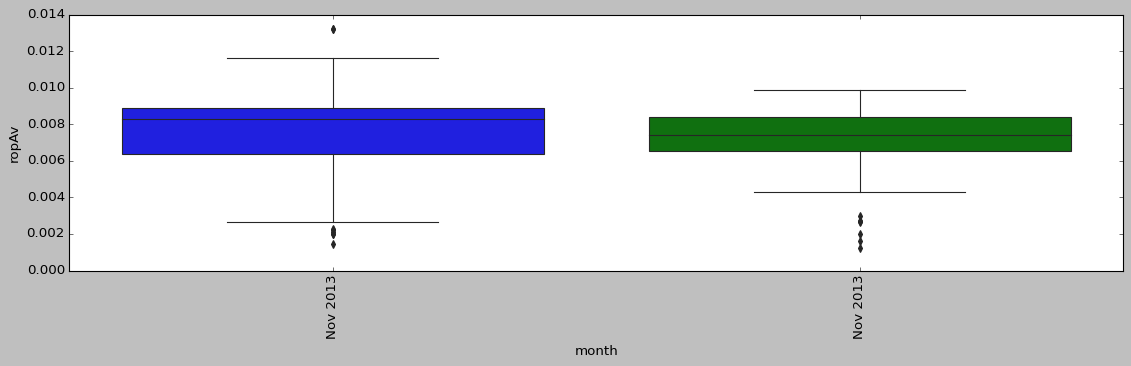

In [ ]:
# Sort "md" from smallest to highest because some values are messed up 
mud_mech_df = mud_mech_df.sort_values("time", axis=0, ascending=True).reset_index(drop=True)

plt.figure(figsize=(17,4))

df = mud_mech_df
df['month'] = df['time'].dt.strftime('%b %Y')

g = sns.boxplot(x=df["month"], y=df["ropAv"])
g.set_xticklabels(df["month"], rotation=90)

plt.show()

In [ ]:
df["time"].describe(datetime_is_numeric=True)

count                              299
mean     2013-11-23 12:26:03.655518464
min                2013-11-10 22:49:01
25%                2013-11-15 16:02:57
50%                2013-11-29 04:03:24
75%                2013-12-01 04:41:24
max                2013-12-01 22:45:30
Name: time, dtype: object

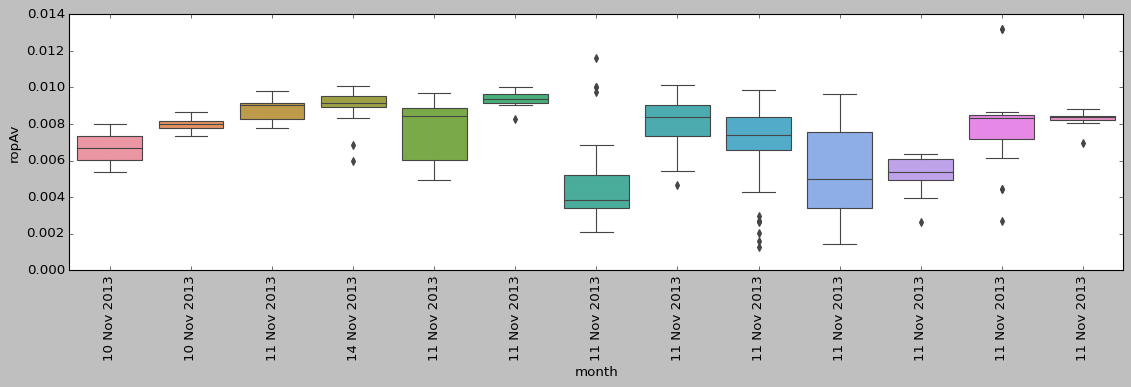

In [ ]:
plt.figure(figsize=(17,4))

df['month'] = df['time'].dt.strftime('%d %b %Y')

g = sns.boxplot(x=df["month"], y=df["ropAv"])
g.set_xticklabels(df["month"], rotation=90)

plt.show()

#### 2D KDE plot; Marginal probability, P(A); Joint probability, P(A∩B); and Conditional probability, P(A|B) 

From: https://stackoverflow.com/questions/17822282/integrate-2d-kernel-density-estimate

In [ ]:
def compute_proba_1d(df, x, xrange):
  from scipy import stats

  ## Estimate KDE 1D
  kdex = stats.gaussian_kde(df[x])

  ## Integrate 
  Px = kdex.integrate_box(xrange[0], xrange[1])

  return Px

def compute_proba_2d(df, x, y, xrange, yrange):
  from scipy import stats

  # Compute marginal probabilities
  Px = compute_proba_1d(df, x, (xrange[0], xrange[1]))
  Py = compute_proba_1d(df, y, (yrange[0], yrange[1]))

  # Compute joint probabilities
  xmin, xmax = df[x].min(), df[x].max()
  ymin, ymax = df[y].min(), df[y].max()

  ## Estimate KDE 2D, P(xny)
  X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
  positions = np.vstack([X.ravel(), Y.ravel()])
  values = np.vstack([df[x], df[y]])
  kdexy = stats.gaussian_kde(values)  

  ## Integrate
  Pxny = kdexy.integrate_box([xrange[0], yrange[0]], [xrange[1], yrange[1]])

  # Compute conditional probability, or Probability of y given x occured, P(y|x)
  Pxy_cond = Pxny / Px

  return Px, Py, Pxny, Pxy_cond

Event A: ropAv between 0.006 and 0.01
Event B: tqAv between 20000 and 25000 

Probability of A is: 0.718202040140772
Probability of B is: 0.46336793173100893
Probability of A and B occur is: 0.29709979222482563
Probability of B given A occurs is: 0.41367160717977386


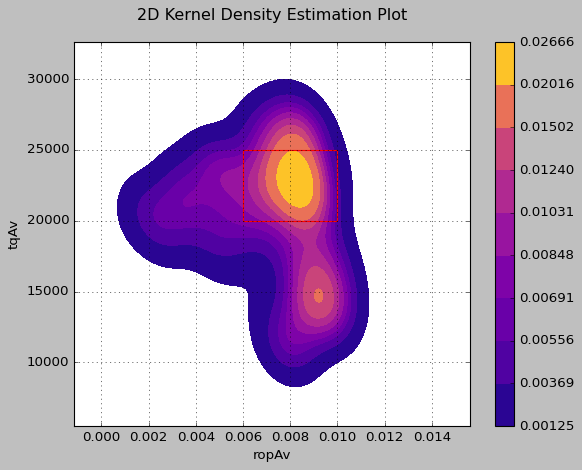

In [ ]:
df = mud_mech_df
x, y = "ropAv", "tqAv"
xbound = (.006, .01) # Bounds where we would like to evaluate probability
ybound = (20000, 25000)

# Compute probabilities
Px, Py, Pxny, Pxy_cond = compute_proba_2d(df, x, y, xbound, ybound)

# Print statements
print('Event A: {} between {} and {}'.format(x, xbound[0], xbound[1]))
print('Event B: {} between {} and {} \n'.format(y, ybound[0], ybound[1]))
print('Probability of A is: {}'.format(Px))
print('Probability of B is: {}'.format(Py))
print('Probability of A and B occur is: {}'.format(Pxny))
print('Probability of B given A occurs is: {}'.format(Pxy_cond))

# Visualize probabilities
sns.kdeplot(data=df, x="ropAv", y="tqAv", fill=True, cbar=True, cmap="plasma")
plt.title("2D Kernel Density Estimation Plot", pad=20)
plt.vlines(xbound[0], ymin=ybound[0], ymax=ybound[1], color="red")
plt.vlines(xbound[1], ymin=ybound[0], ymax=ybound[1], color="red")
plt.hlines(ybound[0], xmin=xbound[0], xmax=xbound[1], color="red")
plt.hlines(ybound[1], xmin=xbound[0], xmax=xbound[1], color="red")

plt.grid()
plt.show()

In [ ]:
@interact

def f(x_axis=logs, y_axis=logs, color_by=color):  
  fig = px.density_contour(df, x=x_axis, y=y_axis)
  fig.update_traces(contours_coloring="fill", contours_showlabels = True)
  fig.show()

interactive(children=(Dropdown(description='x_axis', options=('ropAv', 'wobAv', 'tqAv', 'rpmAv', 'wtMudAv', 'e…

The brightest color, there are 69 points (out of 299) of data having average ROP .0088 to .0091 m/s, and average torque 22,000 to 22,900 Nm.

So, in this case the probability is = 69/299 = 23% ???

### Chromatograph

In [ ]:
mud_chrom_df.columns

Index(['time', 'md', 'methAv', 'methMn', 'methMx', 'ethAv', 'ethMn', 'ethMx',
       'propAv', 'propMn', 'propMx', 'ibutAv', 'ibutMn', 'ibutMx', 'nbutAv',
       'nbutMn', 'nbutMx', 'ipentAv', 'ipentMn', 'ipentMx', 'npentAv',
       'npentMn', 'npentMx', 'gasAv', 'gasPeak', 'gasBackgnd'],
      dtype='object')

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:726: RuntimeWarning:

invalid value encountered in log10



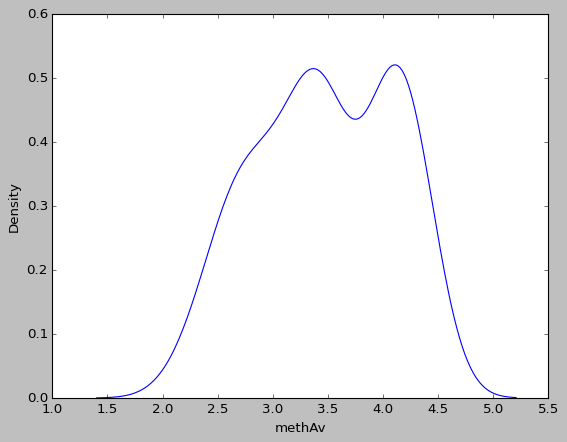

In [ ]:
sns.kdeplot(np.log10(df["methAv"]))

In [ ]:
import plotly.express as px

df = mud_chrom_df
logs = ["methAv", "ethAv", "ibutAv", "nbutAv", "ipentAv", "npentAv", "propAv", "gasAv"]
# color = "type"

# fig = px.scatter_matrix(df, dimensions=logs, color=color, symbol=color,
#                         height=1000, width=1000, title="Scatter Plot Matrix")

fig = px.scatter_matrix(df, dimensions=logs, 
                        height=1000, width=1000, title="Scatter Plot Matrix")

fig.update_traces(showupperhalf=False, diagonal_visible=False)
fig.show()

Yikes! It doesn't look like a good pairplot. Features need transformation, I do here log10. 

In [ ]:
logs = ["methAv", "ethAv", "ibutAv", "nbutAv", "ipentAv", "npentAv", "propAv"]

# Feature transformation, taking log
for i in range(len(logs)):
  df["log_"+logs[i]] = np.log10(df[logs[i]])

# Pairplot
df = mud_chrom_df
logs = ["log_methAv", "log_ethAv", "log_ibutAv", "log_nbutAv", "log_ipentAv",
        "log_npentAv", "log_propAv", "gasAv"]
# color = "type"

# fig = px.scatter_matrix(df, dimensions=logs, color=color, symbol=color,
#                         height=1000, width=1000, title="Scatter Plot Matrix")

fig = px.scatter_matrix(df, dimensions=logs, 
                        height=1000, width=1000, title="Scatter Plot Matrix")

fig.update_traces(showupperhalf=False, diagonal_visible=False)
fig.show()

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:726: RuntimeWarning:

invalid value encountered in log10

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:726: RuntimeWarning:

divide by zero encountered in log10



## Dictionary for unknown mnemonics

There is no description on each of the mnemonics, so I created a dictionary.

In [ ]:
mnemonics = dict({"rop": "Rate of Penetration, m/s", "ecd": "Equivalent Circulating Density, kg/m3", 
                  "tq": "Torque, N.m", "rpm": "Revolutions per Minute, c/s", "wtMud": "Mud Weight, kg/m3",
                  "dxc": "?, unitless", "abundance": "?, %", "gasPeak": "Peak mud gas, ppm", 
                  "gasBackgnd": "Background mud gas, ppm", "gasAv": "Average mud gas, ppm"})
mnemonics

{'abundance': '?, %',
 'dxc': '?, unitless',
 'ecd': 'Equivalent Circulating Density, kg/m3',
 'gasAv': 'Average mud gas, ppm',
 'gasBackgnd': 'Background mud gas, ppm',
 'gasPeak': 'Peak mud gas, ppm',
 'rop': 'Rate of Penetration, m/s',
 'rpm': 'Revolutions per Minute, c/s',
 'tq': 'Torque, N.m',
 'wtMud': 'Mud Weight, kg/m3'}

## Parsing XML using Beautiful Soup (doesn't work)

In [ ]:
!git clone https://github.com/yohanesnuwara/geostatistics

Cloning into 'geostatistics'...
remote: Enumerating objects: 55, done.
remote: Counting objects: 100% (55/55), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 199 (delta 19), reused 0 (delta 0), pack-reused 144
Receiving objects: 100% (199/199), 31.65 MiB | 8.02 MiB/s, done.
Resolving deltas: 100% (78/78), done.


In [ ]:
WITSML_file = "/content/geostatistics/data/volve-realtime/well_15_9_F-15/00001.xml"

# Open the WITSML file
with open(WITSML_file) as file:
    data = file.read()
 
# Parse the file with Beautiful Soup
soup = BeautifulSoup(data, 'xml')

# Mnemonic list
mne = soup.find_all('mnemonicList')
lognames = mne[0].string.split(",") 

# Convert to Pandas dataframe
data = soup.find_all('data')



In [ ]:
WITSML_file = "/content/geostatistics/data/volve-realtime/well_15_9_F-15/trajectory2.xml"

# Reading the WITSML file
with open(WITSML_file) as file:
  data = file.read()

# Parse the WITSML file using the Beautiful library
soup = BeautifulSoup(data, 'xml')

# Convert to Pandas dataframe
data = soup.find_all('data')

data

[]

In [ ]:
WITSML_file = "/content/Realtime.xml"

# Open the WITSML file
with open(WITSML_file) as file:
    data = file.read()
 
# Parse the file with Beautiful Soup
soup = BeautifulSoup(data, 'xml')

colnames = set([str(tag.name) for tag in soup.find_all()])
colnames

{'abundance',
 'chromatograph',
 'codeLith',
 'commonData',
 'commonTime',
 'dTim',
 'dTimCreation',
 'dTimLastChange',
 'dxcAv',
 'ecdTdAv',
 'endMd',
 'ethAv',
 'ethMn',
 'ethMx',
 'gasAv',
 'gasBackgnd',
 'gasPeak',
 'geologyInterval',
 'ibutAv',
 'ibutMn',
 'ibutMx',
 'ipentAv',
 'ipentMn',
 'ipentMx',
 'itemState',
 'lithPc',
 'lithology',
 'mdBottom',
 'mdTop',
 'methAv',
 'methMn',
 'methMx',
 'mudGas',
 'mudLog',
 'mudLogCompany',
 'mudLogs',
 'name',
 'nameWell',
 'nameWellbore',
 'nbutAv',
 'nbutMn',
 'nbutMx',
 'npentAv',
 'npentMn',
 'npentMx',
 'priv_dTimReceived',
 'priv_ipLastChange',
 'priv_ipOwner',
 'priv_userLastChange',
 'priv_userOwner',
 'propAv',
 'propMn',
 'propMx',
 'qualifier',
 'relatedLog',
 'ropAv',
 'ropMn',
 'ropMx',
 'rpmAv',
 'sourceName',
 'startMd',
 'tqAv',
 'type',
 'typeLithology',
 'wobAv',
 'wtMudAv'}

In [ ]:
a = soup.find_all("ethAv")
a

[<ethAv uom="ppm">-2978425532</ethAv>,
 <ethAv uom="ppm">-999</ethAv>,
 <ethAv uom="ppm">0</ethAv>,
 <ethAv uom="ppm">0</ethAv>,
 <ethAv uom="ppm">0</ethAv>,
 <ethAv uom="ppm">0</ethAv>,
 <ethAv uom="ppm">-7613</ethAv>,
 <ethAv uom="ppm">0</ethAv>,
 <ethAv uom="ppm">0</ethAv>,
 <ethAv uom="ppm">0</ethAv>,
 <ethAv uom="ppm">0</ethAv>,
 <ethAv uom="ppm">0</ethAv>,
 <ethAv uom="ppm">0</ethAv>,
 <ethAv uom="ppm">0</ethAv>,
 <ethAv uom="ppm">0</ethAv>,
 <ethAv uom="ppm">-799920000</ethAv>,
 <ethAv uom="ppm">-945851351</ethAv>,
 <ethAv uom="ppm">0</ethAv>,
 <ethAv uom="ppm">0</ethAv>,
 <ethAv uom="ppm">0</ethAv>,
 <ethAv uom="ppm">0</ethAv>,
 <ethAv uom="ppm">0</ethAv>,
 <ethAv uom="ppm">0</ethAv>,
 <ethAv uom="ppm">0</ethAv>,
 <ethAv uom="ppm">0</ethAv>,
 <ethAv uom="ppm">0</ethAv>,
 <ethAv uom="ppm">0</ethAv>,
 <ethAv uom="ppm">0</ethAv>,
 <ethAv uom="ppm">2</ethAv>,
 <ethAv uom="ppm">14</ethAv>,
 <ethAv uom="ppm">13</ethAv>,
 <ethAv uom="ppm">14</ethAv>,
 <ethAv uom="ppm">12</ethAv>,
 <et

In [ ]:
WITSML_file = "/content/Realtime.xml"

# Open the WITSML file
with open(WITSML_file) as file:
    data = file.read()
 
# Parse the file with Beautiful Soup
soup = BeautifulSoup(data, 'xml')

colnames = set([str(tag.name) for tag in soup.find_all()])

# Convert into dataframe with only selected column names
columns = ["ethAv"]
df2 = pd.DataFrame()
for col in columns:
    df2[col] = [float(x.text) for x in soup.find_all(col)]
    print(len(df2[col]))

# df2

99
